In [1]:
import matplotlib.pyplot as plt
import numpy as np


# Define Function and Derivative

In [2]:
def func(x1, x2):
    return (x1**2 + x2 - 11)**2 + (2*x1 + x2**2 - 7)**2

def func_grad(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 4*(x1**3) + 4*x1*x2 - 36*x1 + 4*x2**2 - 28 , 4*(x2**3) + 2*x2 + 8*x1*x2 + 2*x1**2 - 26*x2 - 22

# Define Optimizer Class

In [3]:
class Optimizers:
    
    def __init__(self, lr_schedule):
        self.lr_schedule = lr_schedule
  
    def lr(self, rate , t):
        if self.lr_schedule == "constant":
            return self.constant_lr(rate)
        elif self.lr_schedule == "power":
            return self.power_lr(rate, t)

    def constant_lr(self, rate):
        return rate
    
    def power_lr(self, rate, t):
        c = 1
        s = 10
        return rate/(1 + t/s)**c

    def gradient_descent(self, x1, x2, t1, t2, func_grad, rate, t):
        gr_x1, gr_x2 = func_grad(x1, x2)
        return x1 - self.lr(rate, t)*gr_x1, x2 - self.lr(rate, t)*gr_x2, 0, 0
    
    def stochastic_gradient_descent(self, x1, x2, t1, t2, func_grad , rate , t):
        gr_x1, gr_x2 = func_grad(x1, x2)
        gr_x1 += np.random.normal(0, 1)
        gr_x2 += np.random.normal(0, 1)
        return x1 - self.lr(rate,t)*gr_x1, x2 - self.lr(rate,t)*gr_x2, 0, 0

    def gradient_descent_with_momentum(self, x1, x2, v1, v2, func_grad , rate ,t):
        alpha = 0.9
        gr_x1, gr_x2 = func_grad(x1, x2)
        v1 = alpha*v1 - self.lr(rate,t)*gr_x1
        v2 = alpha*v2 - self.lr(rate,t)*gr_x2
        return x1 + v1, x2 + v2, v1, v2

    def nesterov_gradient_descent_with_momentum(self, x1, x2, v1, v2, func_grad , rate , t):
        alpha=0.9
        x1 += alpha*v1
        x2 += alpha*v2
        gr_x1, gr_x2 = func_grad(x1, x2)
        v1 = alpha*v1 - self.lr(rate, t)*gr_x1
        v2 = alpha*v2 - self.lr(rate, t)*gr_x2
        return x1 + v1, x2 + v2, v1, v2

    def ada_grad(self, x1, x2, r1, r2, func_grad, rate , t):
        delta = 1e-7
        gr_x1, gr_x2 = func_grad(x1, x2)
        r1 += gr_x1**2
        r2 += gr_x2**2
        x1 -= self.lr(rate, t)/(delta + np.sqrt(r1))*gr_x1
        x2 -= self.lr(rate, t)/(delta + np.sqrt(r2))*gr_x2
        return x1, x2, r1, r2

    def rmsprop(self, x1, x2, r1, r2, func_grad , rate , t):
        delta = 1e-7
        rho = 0.9
        gr_x1, gr_x2 = func_grad(x1, x2)
        r1 = r1*rho + (1-rho)*gr_x1**2
        r2 = r2*rho + (1-rho)*gr_x2**2
        x1 -= self.lr(rate, t)/np.sqrt(delta+r1)*gr_x1
        x2 -= self.lr(rate, t)/np.sqrt(delta+r2)*gr_x2
        return x1, x2, r1, r2
   
    def adam(self, x1, x2, s1, s2, r1, r2, t, func_grad,rate):
        delta, rho1, rho2 = 1e-8, 0.9, 0.999
        gr_x1, gr_x2 = func_grad(x1, x2)

        s1 = rho1*s1 + (1-rho1)*gr_x1
        s2 = rho1*s2 + (1-rho1)*gr_x2

        r1 = rho2*r1 + (1-rho2)*gr_x1**2
        r2 = rho2*r2 + (1-rho2)*gr_x2**2

        shat1 = s1/(1-rho1**(t+1))
        shat2 = s2/(1-rho1**(t+1))

        rhat1 = r1/(1-rho2**(t+1))
        rhat2 = r2/(1-rho2**(t+1))

        x1 -= self.lr(rate, t)*shat1/(np.sqrt(rhat1)+delta)
        x2 -= self.lr(rate, t)*shat2/(np.sqrt(rhat2)+delta)

        return x1, x2, s1, s2, r1, r2
    
    def nesterov_rmsprop_with_momentum(self, x1, x2, v1, v2,r1,r2, func_grad , rate , t):
        delta = 1e-7
        rho = 0.9
        alpha=0.9
        x1 += alpha*v1
        x2 += alpha*v2
        gr_x1, gr_x2 = func_grad(x1, x2)
        r1 = r1*rho + (1-rho)*gr_x1**2
        r2 = r2*rho + (1-rho)*gr_x2**2
        v1 = alpha*v1 - self.lr(rate, t)/np.sqrt(delta+r1)*gr_x1
        v2 = alpha*v2 - self.lr(rate, t)/np.sqrt(delta+r2)*gr_x2
        return x1 + v1, x2 + v2, v1, v2 , r1 , r2

        
        

# Define search functions for getting dots movement steps based on gradient functions

In [4]:
def search(optimizer, func_grad, rate, iteration=10):
    x_iterations_list = []
    start_points = [(1.5, -4), (-2, -5), (-1, 1)]

    for start_point in start_points:
        x1, x2, t1, t2 = start_point[0], start_point[1], 0, 0
        x_iterations = [(x1, x2)]
        for i in range(iteration):
            x1, x2, t1, t2 = optimizer(x1, x2, t1, t2, func_grad, rate, i+1)
            x_iterations.append((x1, x2))
        print("epoch {}, x1:{}, x2:{}".format(i+1, x1, x2))
        x_iterations_list.append(x_iterations)

    return x_iterations_list

In [27]:
def search_rsmsprop(optimizer, func_grad, rate, iteration=10):
    x_iterations_list = []
    start_points = [(1.5, -4), (-2, -5), (-1, 1)]
    for start_point in start_points:
        x1, x2, r1, r2 , v1, v2 = start_point[0], start_point[1], 0, 0 , 0 , 0
        x_iterations = [(x1, x2)]
        for i in range(iteration):
            x1, x2, r1, r2 , v1 , v2 = optimizer(x1, x2, r1, r2 , v1, v2, func_grad, rate, i+1)
            x_iterations.append((x1, x2))
        print("epoch {}, x1:{}, x2:{}".format(i+1, x1, x2))
        x_iterations_list.append(x_iterations)
    return x_iterations_list

In [26]:
def search_adam(optimizer_adam, func_grad,rate, iteration=10):
    x_iterations_list = []
    start_points = [(1.5, -4), (-2, -5), (-1, 1)]
    for start_point in start_points:
        x1, x2, s1, s2, r1, r2 = start_point[0], start_point[1], 0, 0 , 0 , 0
        x_iterations = [(x1, x2)]
        for t in range(iteration):
            x1, x2, s1, s2, r1, r2 = optimizer_adam(x1, x2, s1, s2, r1, r2,t, func_grad,rate)
            x_iterations.append((x1, x2))
        print("epoch {}, x1:{}, x2:{}".format(t+1, x1, x2))
        x_iterations_list.append(x_iterations)
    return x_iterations_list

## Define a function to plot function and the movements of 3 different dots on surface

In [7]:
def search_path(func, x_iterations_list):
    # Create a meshgrid of x1 and x2 
    x1, x2 = np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))
    
    # Create a 3D plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(x1, x2, func(x1, x2), cmap='jet' ,alpha=1)

    # Plot the dot movement
    colors = ['r', 'g', 'k']

    for i, x_iterations in enumerate(x_iterations_list):

        #ax.plot(x1, x2, color=colors[i], marker='o', label=f'Start Point {i+1}')
        dot_x1, dot_x2 = zip(*x_iterations[:-1])
        ax.plot(dot_x1, dot_x2, [func(x1, x2) for x1, x2 in x_iterations[:-1]], color=colors[i],marker='o', linestyle='-', markersize=5, linewidth=1,zorder=10)

    # Set labels and title
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Function Value')
    ax.set_title('Function Surface with Gradient Vectors and Dot Movement')
    ax.view_init(30, 110)

    plt.show()   

# Plot all methods of optimizers with three different start point

### gradient_descent

epoch 10, x1:3.3196002234518107, x2:-1.5006445569768163
epoch 10, x1:-3.777546432725252, x2:-3.707974334668916
epoch 10, x1:-1.5685126083103067, x2:2.906870194615297


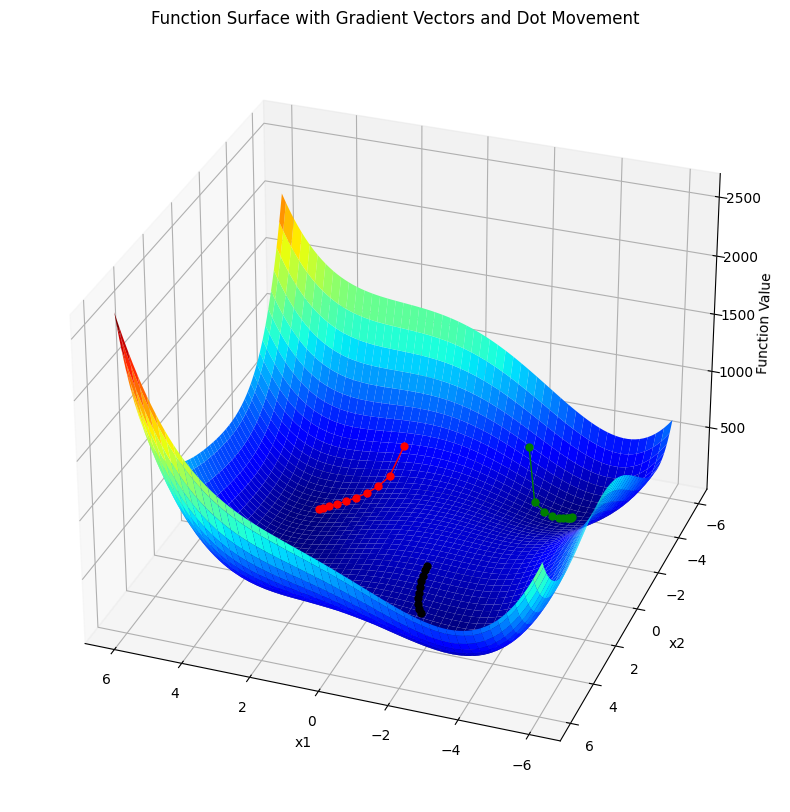

In [10]:
opt = Optimizers("constant")
search_path(func, search(opt.gradient_descent, func_grad, 0.004))

epoch 10, x1:2.9162356234281592, x2:-1.842479287298133
epoch 10, x1:-3.6661248963765085, x2:-3.6193319269624724
epoch 10, x1:-1.2667696526071, x2:2.3992550575252434


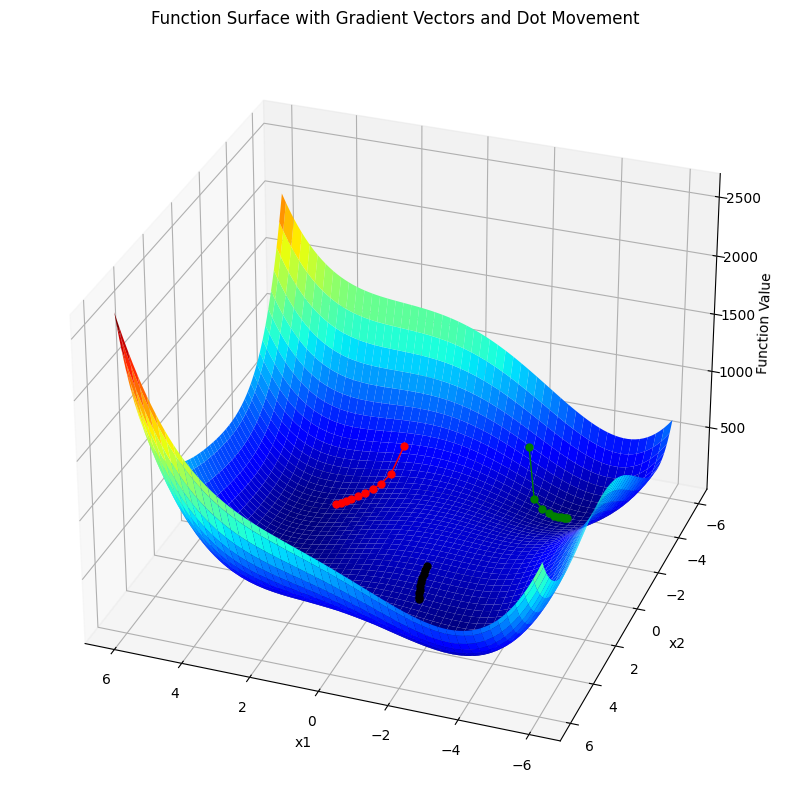

In [11]:
opt = Optimizers("power")
search_path(func, search(opt.gradient_descent, func_grad, 0.004))

### stochastic_gradient_descent

epoch 10, x1:3.316086703529259, x2:-1.5036682155273013
epoch 10, x1:-3.771857941773081, x2:-3.705373289872715
epoch 10, x1:-1.5548924666685737, x2:2.904098565301999


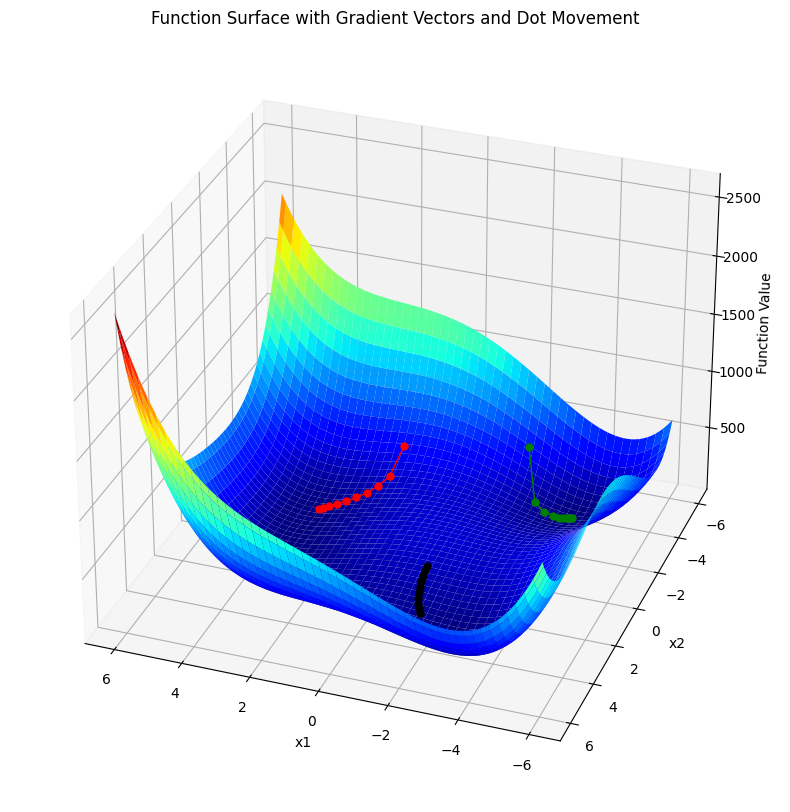

In [12]:
opt = Optimizers("constant")
search_path(func, search(opt.stochastic_gradient_descent, func_grad , 0.004))

epoch 10, x1:2.910020389307052, x2:-1.8384783456636873
epoch 10, x1:-3.6641990091116194, x2:-3.625803405991869
epoch 10, x1:-1.2754759802952575, x2:2.410265640273775


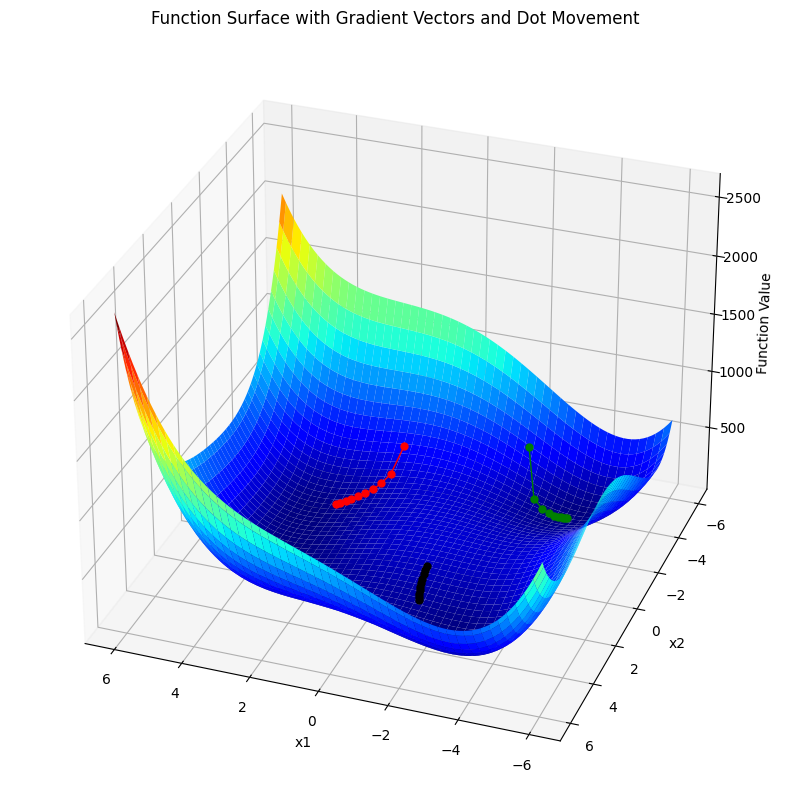

In [13]:
opt = Optimizers("power")
search_path(func, search(opt.stochastic_gradient_descent, func_grad , 0.004))

### gradient_descent_with_momentum

epoch 10, x1:1.424936497229634, x2:2.0514177925981736
epoch 10, x1:-0.646895261043626, x2:-2.247612109918988
epoch 10, x1:-3.6353655090809043, x2:3.054076519884429


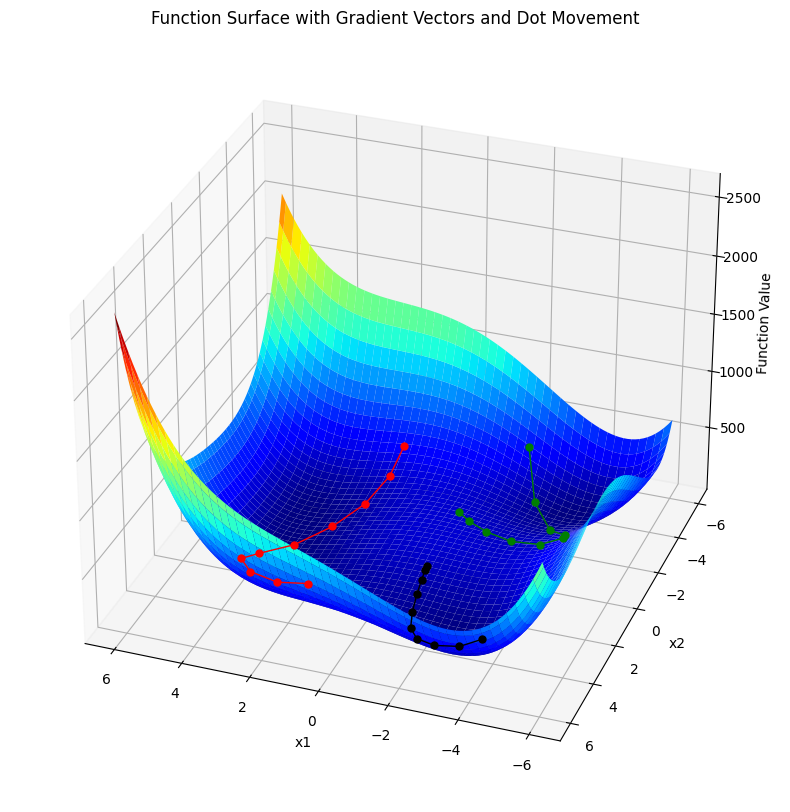

In [14]:
opt = Optimizers("constant")
search_path(func, search(opt.gradient_descent_with_momentum, func_grad , 0.004))

epoch 10, x1:2.7616381134864167, x2:2.7244487187293975
epoch 10, x1:-1.140423579326383, x2:-0.5927118813755669
epoch 10, x1:-3.026889874458633, x2:3.800627730360833


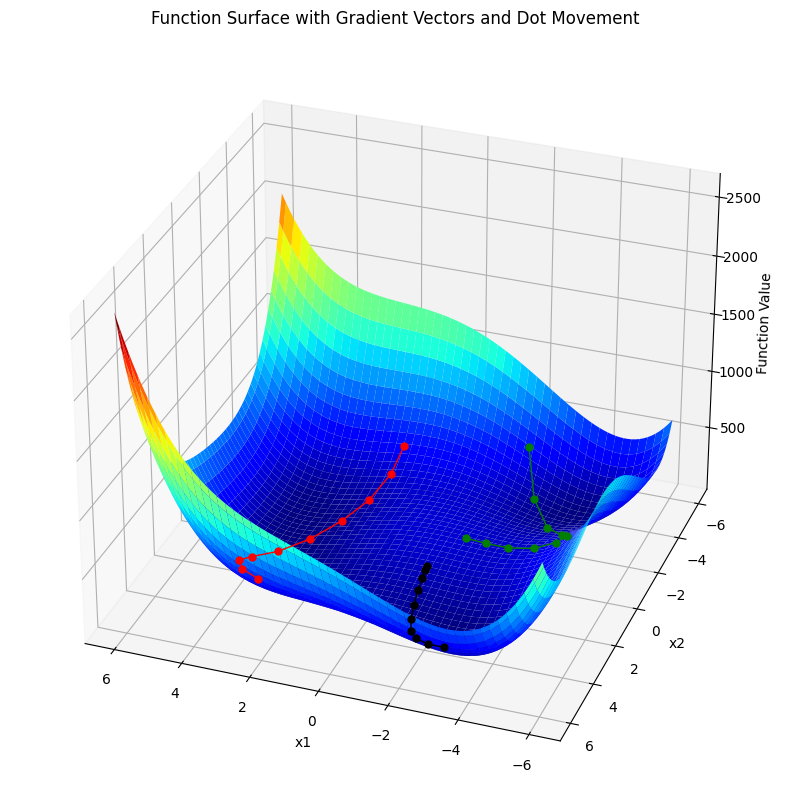

In [15]:
opt = Optimizers("power")
search_path(func, search(opt.gradient_descent_with_momentum, func_grad , 0.004))

### nesterov_gradient_descent_with_momentum

epoch 10, x1:-0.022497576104115097, x2:1.182739358205236
epoch 10, x1:1.5569608604878793, x2:1.034770428364431
epoch 10, x1:-1.991758968191891, x2:3.3578502515728976


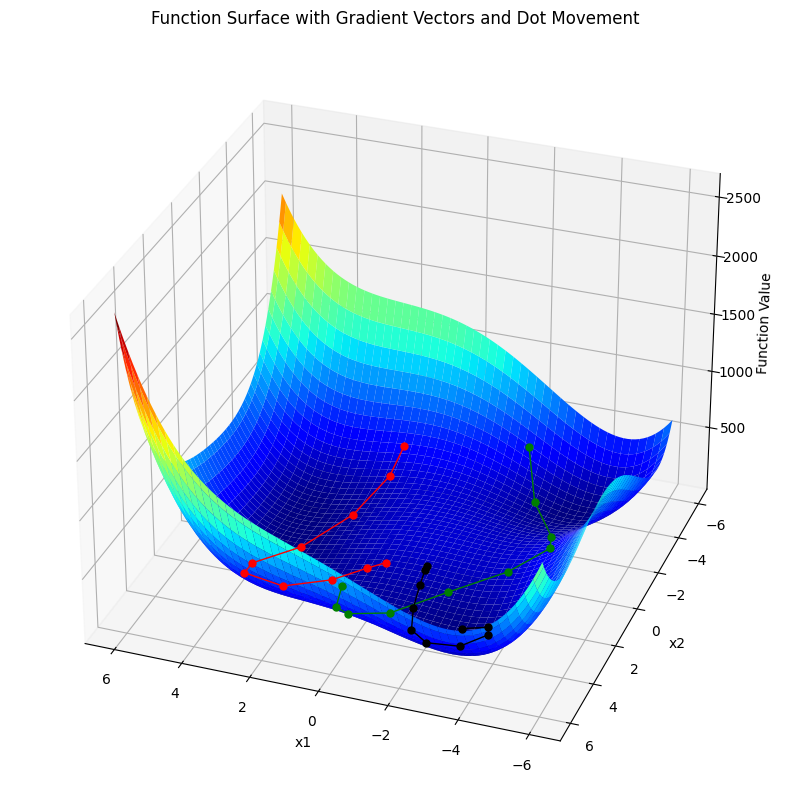

In [16]:
opt = Optimizers("constant")
search_path(func, search(opt.nesterov_gradient_descent_with_momentum, func_grad , 0.004))

epoch 10, x1:0.40616468085999713, x2:1.1693767700130522
epoch 10, x1:0.8222388047396681, x2:3.325552502411008
epoch 10, x1:-3.409641055950347, x2:2.8019802846598827


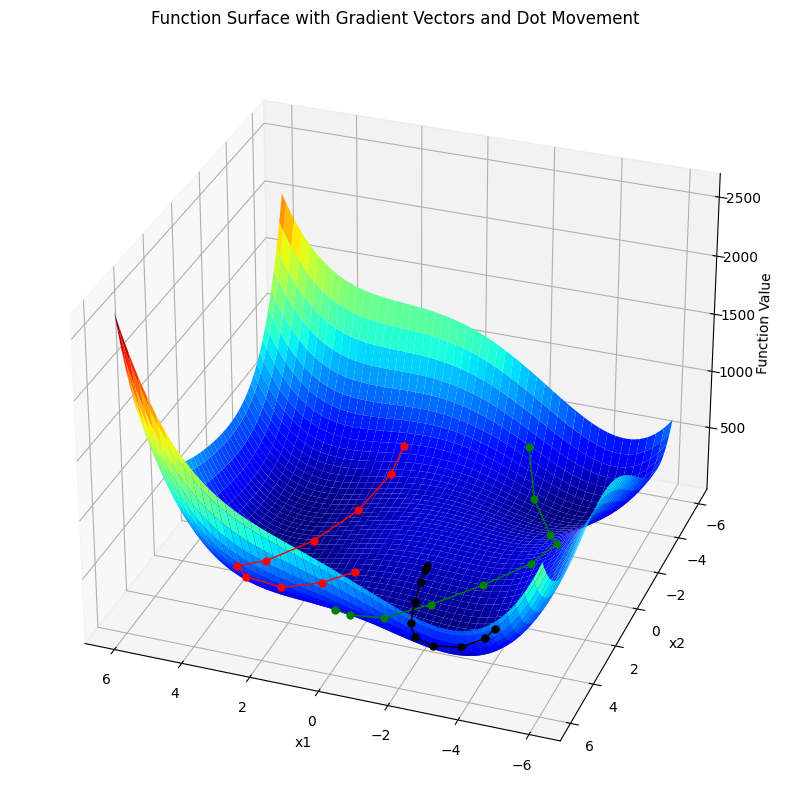

In [17]:
opt = Optimizers("power")
search_path(func, search(opt.nesterov_gradient_descent_with_momentum, func_grad , 0.004))

### AdaGrad

epoch 10, x1:1.5202197073758281, x2:-3.9799689393498836
epoch 10, x1:-2.020063380798776, x2:-4.979992338359029
epoch 10, x1:-1.0205284671850392, x2:1.0201226348125023


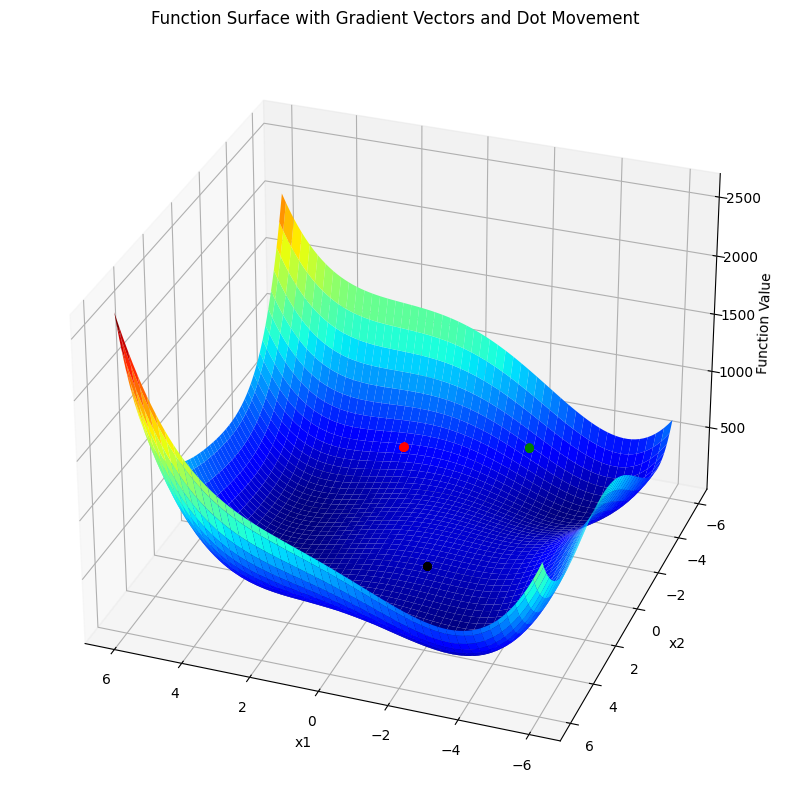

In [18]:
opt = Optimizers("constant")
search_path(func, search(opt.ada_grad, func_grad , 0.004))

epoch 10, x1:1.5144865378039003, x2:-3.985604681115448
epoch 10, x1:-2.0144109226456592, x2:-4.985615917170254
epoch 10, x1:-1.0146369933196708, x2:1.0144394420311587


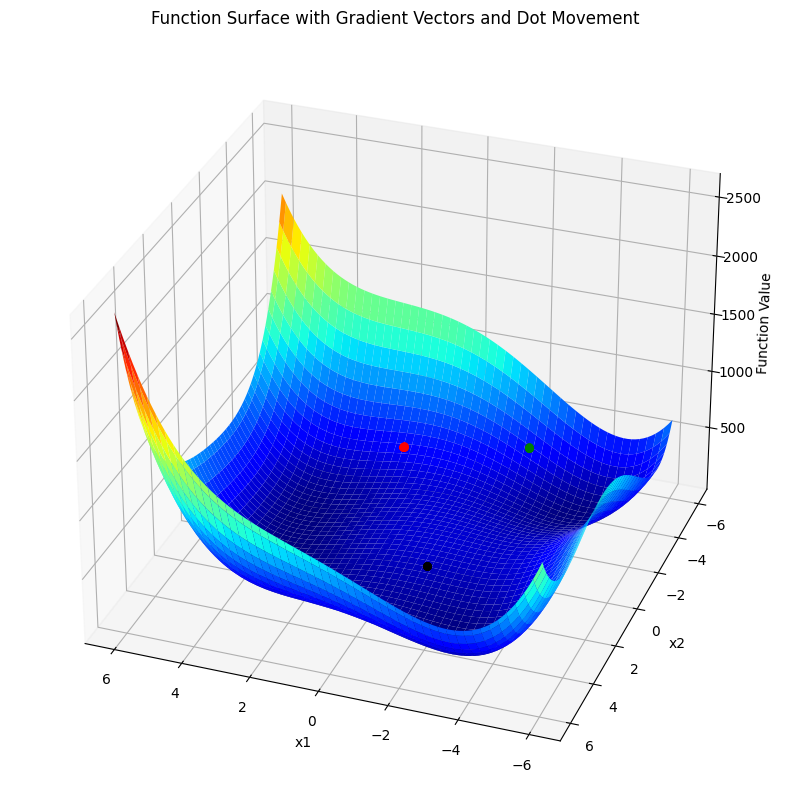

In [19]:
opt = Optimizers("power")
search_path(func, search(opt.ada_grad, func_grad , 0.004))

### RMSPROP

epoch 10, x1:1.5706641498136575, x2:-3.9312223525912384
epoch 10, x1:-2.0691094150874227, x2:-4.931474685393177
epoch 10, x1:-1.073417331066921, x2:1.0697279365397727


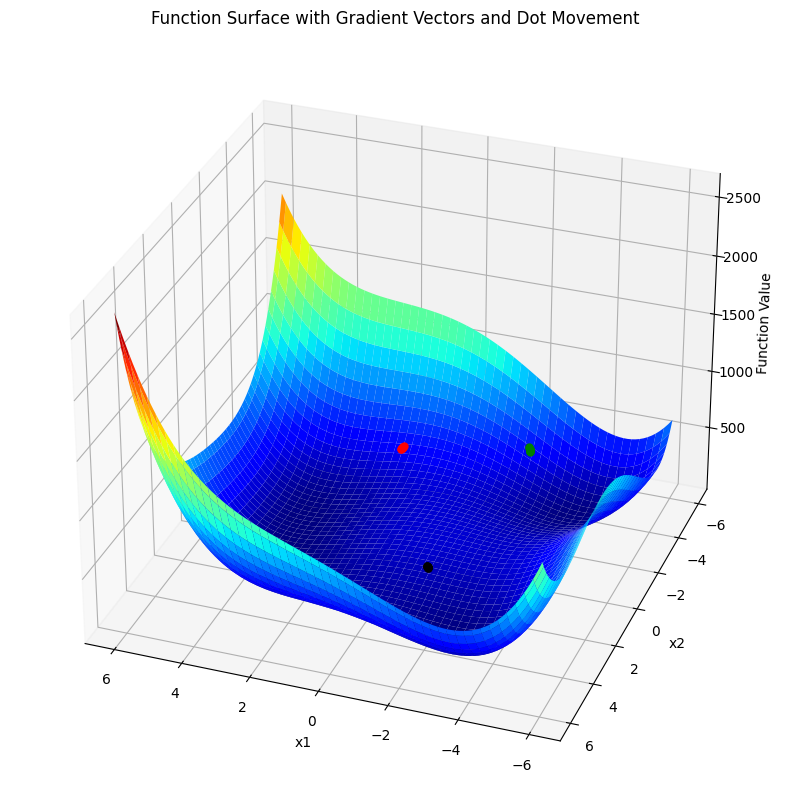

In [20]:
opt = Optimizers("constant")
search_path(func, search(opt.rmsprop, func_grad , 0.004))

epoch 10, x1:1.5497608919359374, x2:-3.9511418571371
epoch 10, x1:-2.0490157653738885, x2:-4.951259410740838
epoch 10, x1:-1.0511253554554085, x2:1.0493068711553126


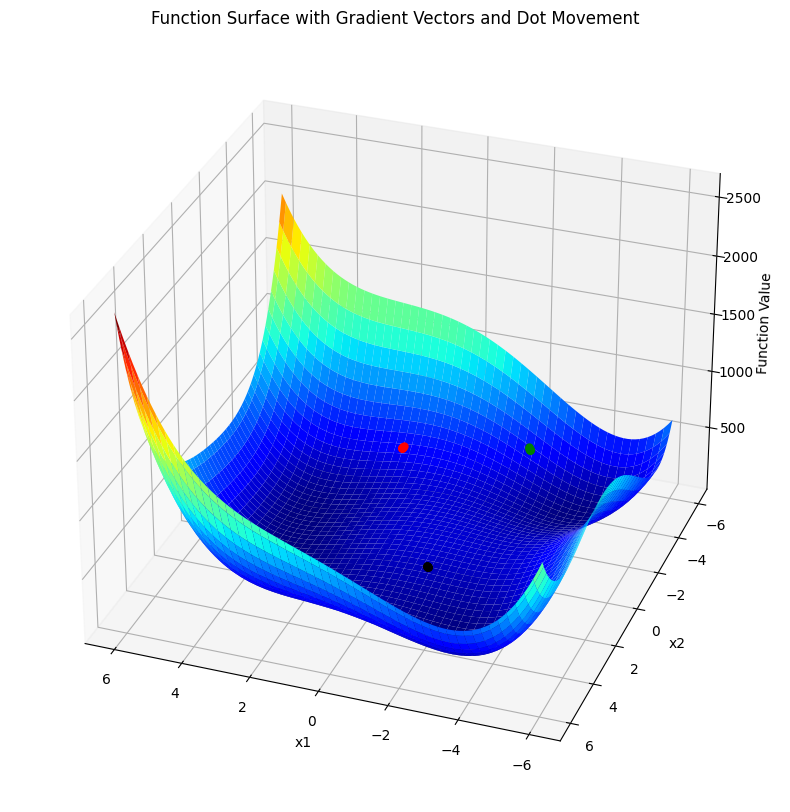

In [21]:
opt = Optimizers("power")
search_path(func, search(opt.rmsprop, func_grad , 0.004))

### nesterov_rmsprop_with_momentum

epoch 10, x1:2.1060129602398887, x2:-3.451712973551534
epoch 10, x1:-2.559264653819244, x2:-4.462769799403524
epoch 10, x1:-1.6578416747449534, x2:1.5824224912303668


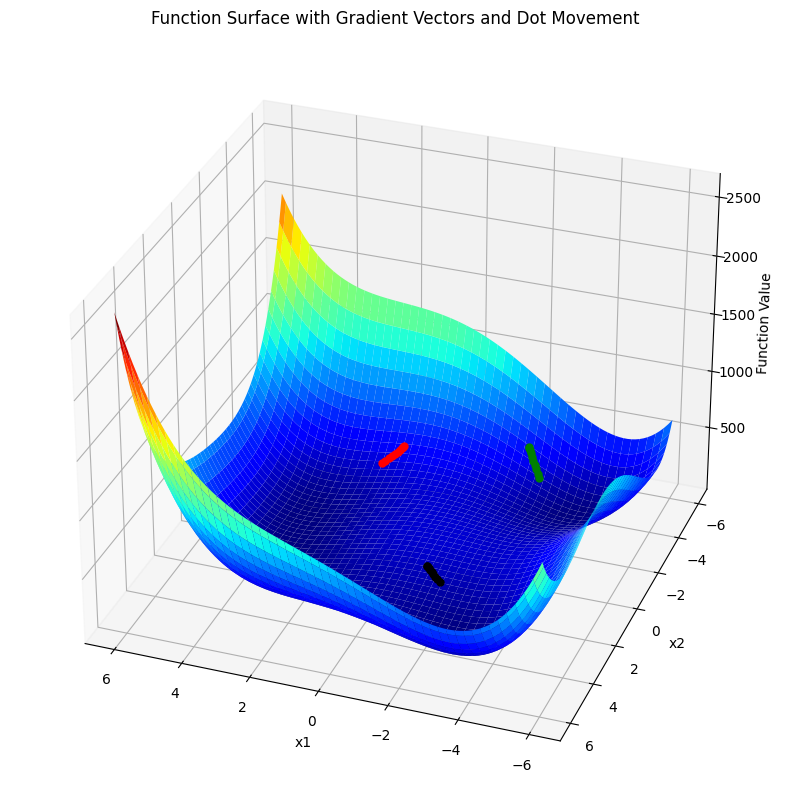

In [28]:
opt = Optimizers("constant")
search_path(func, search_rsmsprop(opt.nesterov_rmsprop_with_momentum, func_grad , 0.004))

epoch 10, x1:1.9560686968111922, x2:-3.5758388956195666
epoch 10, x1:-2.430156776001663, x2:-4.5813459431482295
epoch 10, x1:-1.4884626475815415, x2:1.4421794974202455


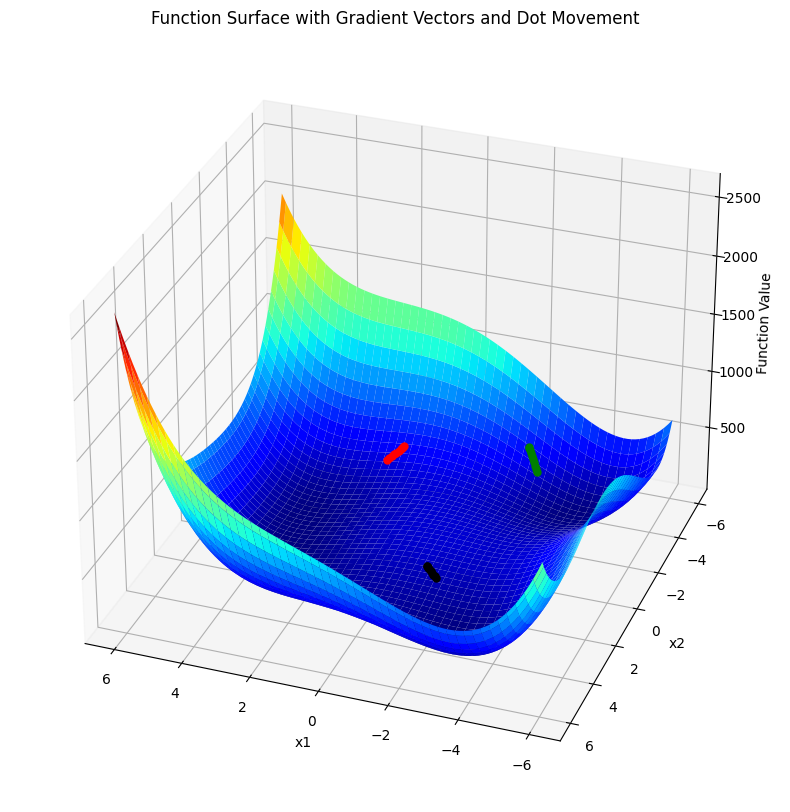

In [29]:
opt = Optimizers("power")
search_path(func, search_rsmsprop(opt.nesterov_rmsprop_with_momentum, func_grad , 0.004))

### Adam

epoch 10, x1:1.5400857556201415, x2:-3.9600357208025434
epoch 10, x1:-2.0399860925757567, x2:-4.960051873557201
epoch 10, x1:-1.0402521394005382, x2:1.0400251836328251


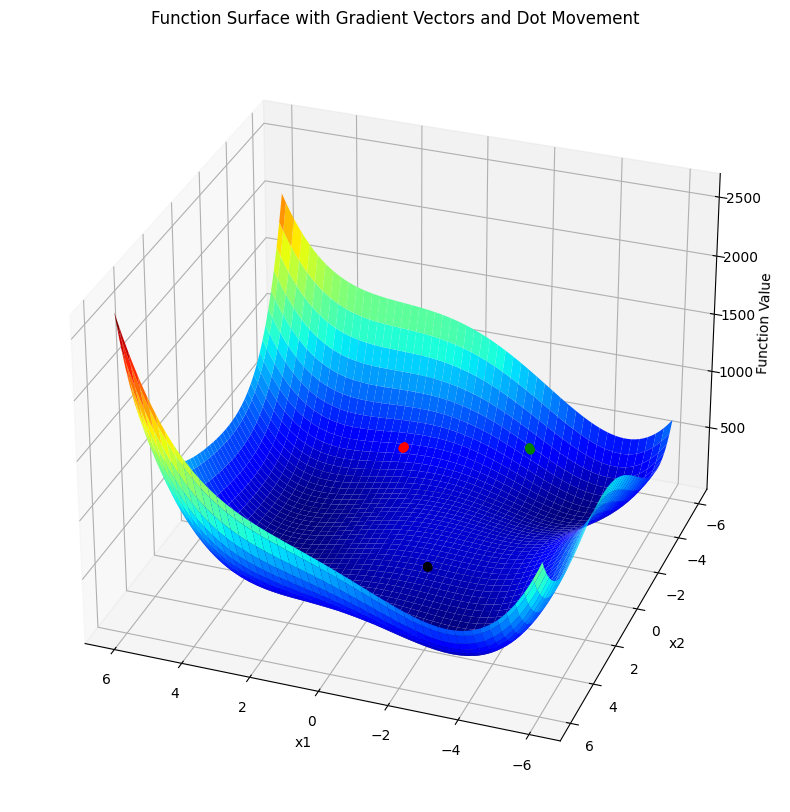

In [30]:
opt = Optimizers("constant")
search_path(func, search_adam(opt.adam, func_grad ,0.004))

epoch 10, x1:1.5287922397271014, x2:-3.9712660914413207
epoch 10, x1:-2.028744278248279, x2:-4.971273701027426
epoch 10, x1:-1.0288755025283765, x2:1.028762890296603


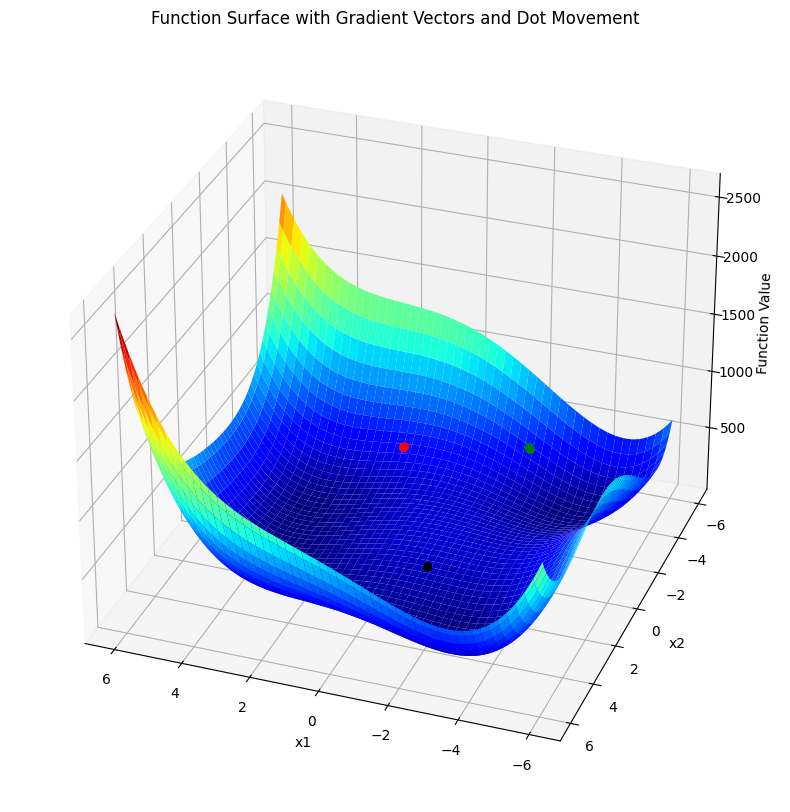

In [31]:
opt = Optimizers("power")
search_path(func, search_adam(opt.adam, func_grad ,0.004))